In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

In [2]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_der(z):
    return sigmoid(z) * (1 - sigmoid(z))

def relu(z):
    return np.maximum(z,0)

def relu_der(z):
    return (z >= 0.0).astype(float)

In [3]:
def initialize_parameters(dimensions):
    params = {}
    L = len(dimensions)
    for l in range(1,L):
        params["W" + str(l)] = np.random.randn(dimensions[l],dimensions[l-1]) * np.sqrt(2/dimensions[l-1])
        params["b" + str(l)] = np.zeros((dimensions[l],1))
        
        assert params["W" + str(l)].shape == (dimensions[l],dimensions[l-1])
    
    return params

In [4]:
def forward_layer(W, X, b, activation):
    
    Z = np.dot(W, X) + b
    A = np.zeros(Z.shape)
            
    if activation == "sigmoid":
         A = sigmoid(Z)
    elif activation == "relu":
         A = relu(Z)
    cache = np.copy(Z)
    
    assert A.shape == Z.shape
             
    return A,cache

In [5]:
def forward(X, params,printA=False):
    
    cache = {"Z0": X}
    L = len(params)//2 + 1
    y_hat = np.copy(X)
    
    # Hidden layers = relu
    for l in range(1,L-1):
        y_hat,cache_layer = forward_layer(params["W" + str(l)], y_hat, params["b" + str(l)], "relu")
        cache["Z" + str(l)] = np.copy(cache_layer)
                
    # Final layer = sigmoid 
    y_hat,cache_layer = forward_layer(params["W" + str(L-1)], y_hat, params["b" + str(L-1)], "sigmoid")
    cache["Z" + str(L-1)] = np.copy(cache_layer)
        
    return y_hat,cache

In [6]:
def compute_cost(y, y_hat):
    
    m = y.shape[1]
    cost = (-1 / m) * np.sum(np.multiply(y, np.log(y_hat)) + np.multiply(1 - y, np.log(1 - y_hat)))

    cost = np.squeeze(cost)
    
    return cost

In [7]:
def backward_layer(W, dZn, Z, m):
        
    dZn = relu_der(dZn) * dZn
    dZ = np.dot(W.T, dZn)
    dW = (1/m) * np.dot(dZn, Z.T)
    db = (1/m) * np.sum(dZn,axis = 1,keepdims = True)
    
    return dZ,dW,db

In [8]:
def backward(Y,y_hat,params,cache):
    
    m = Y.shape[1]
    grads = {}
    L = len(params)//2 + 1
    
    # Derivative of cost function
    dy_hat = -(y_hat-Y)/(y_hat*(1-y_hat))
    #dy_hat = y_hat - Y
        
    # Derivative of sigmoid layer
    grads["dZ" + str(L-1)] = sigmoid_der(dy_hat) * dy_hat
    
    for l in range(L-2,-1,-1):
        
        dZ,dW,db = backward_layer(params["W" + str(l+1)], grads["dZ" + str(l+1)], cache["Z" + str(l)], m)
        
        grads["dZ" + str(l)] = np.copy(dZ)
        grads["dW" + str(l+1)] = np.copy(dW)
        grads["db" + str(l+1)] = np.copy(db)
        
    return grads

In [9]:
def update(params,grads,learning_rate):
    L = len(params)//2 + 1
    for l in range(1,L):
        params["W" + str(l)] = params["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        params["b" + str(l)] = params["b" + str(l)] - learning_rate * grads["db" + str(l)]
    return params

In [10]:
def initialize_adam(params):
    v = {}
    s = {}
    L = len(params)//2 + 1
    
    for l in range(1,L):
        v["dW" + str(l)] = np.zeros(params["W" + str(l)].shape)
        v["db" + str(l)] = np.zeros(params["b" + str(l)].shape)        
        s["dW" + str(l)] = np.zeros(params["W" + str(l)].shape)
        s["db" + str(l)] = np.zeros(params["b" + str(l)].shape)
    
    return v,s

def update_adam(params,grads,learning_rate,beta1,beta2,v,s,t=2):
    L = len(params)//2 + 1
    
    for l in range(1,L):
        
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads["dW" + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads["db" + str(l)]
        
        #v["dW" + str(l)] = v["dW" + str(l)] / (1 - beta1**t)
        #v["db" + str(l)] = v["db" + str(l)] / (1 - beta1**t)
        
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * (grads["dW" + str(l)]**2)
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * (grads["db" + str(l)]**2)
        
        #s["dW" + str(l)] = s["dW" + str(l)] / (1 - beta2**t)
        #s["db" + str(l)] = s["db" + str(l)] / (1 - beta2**t)
        
        params["W" + str(l)] = params["W" + str(l)] - learning_rate * v["dW" + str(l)] / np.sqrt(s["dW" + str(l)] + 1e-8) 
        params["b" + str(l)] = params["b" + str(l)] - learning_rate * v["db" + str(l)] / np.sqrt(s["db" + str(l)] + 1e-8)
    return params

In [11]:
# Data input
df = pd.read_pickle('./train.pkl')

X = df[['red','green','blue']]
X = X.to_numpy()
X = X.T

Y = df[['color']]
Y = Y.to_numpy()
Y = Y.reshape(-1,Y.shape[0])

# Set the dimensions and initialize them
dimensions = [3,8,8,8,4,1]
params = initialize_parameters(dimensions)

alpha = 0.00001
costs = []
v, s = initialize_adam(params)

iterations = 5000

for i in range(0,iterations):
    
    # Forward propagation
    y_hat,cache = forward(X,params)
    
    # Compute cost
    cost = compute_cost(Y,y_hat)
    costs.append(cost)
    
    # Backward propagation
    grads = backward(Y,y_hat,params,cache)
    
    # Update the parameters 
    #params = update(params,grads,alpha)
    params = update_adam(params,grads,alpha,0.9,0.999,v,s)
        
    if i % (iterations//10) == 0:
        print("average cost")
        print(cost)
        print()

average cost
0.710637980583468

average cost
0.6855548161443441

average cost
0.6765037730677822

average cost
0.67065650879265

average cost
0.666550197941799

average cost
0.6635635737275473

average cost
0.6613060122016501

average cost
0.6596080700343159

average cost
0.658492428165894

average cost
0.6578637746748512



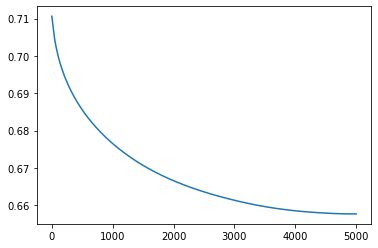

In [12]:
plt.plot(costs)

In [13]:
# For Accuracy

def getAccuracy(dataset):
    df_test = pd.read_pickle('./'+ dataset +'.pkl')

    X1 = df_test[['red','green','blue']]
    X1 = X1.to_numpy()
    X1 = X1.T

    Y1 = df_test[['color']]
    Y1 = Y1.to_numpy()
    Y1 = Y1.reshape(-1,Y1.shape[0])

    print(df_test.shape)

    out,cac = forward(X1,params)
   
    X1 = X1.T
    Y1 = Y1.T
    out = (out > 0.5).astype(int)
    out = out.T
    correctness = 0
    for i in range(len(X1)):
        if(Y1[i] == out[i]):
            correctness += 1

    return correctness/len(X1) * 100

In [14]:
# Check Accuracy

print("Train Accuracy", getAccuracy('train'))
print("Test Accuracy", getAccuracy('test'))
print("Dev Accuracy", getAccuracy('dev'))

(1515, 4)
Train Accuracy 73.3993399339934
(85, 4)
Test Accuracy 78.82352941176471
(84, 4)
Dev Accuracy 76.19047619047619


In [21]:
# Save the weights and biases from the training as json
import json

parameters = {}

for key in params:
    parameters[key] = params[key].tolist()

with open('params.json', 'w') as json_file:
  json.dump(parameters, json_file)